# Лекция №13

## На прошлой лекции

1. [Термодинамика OpenFOAM](#thermo)
2. [Метод Годунова](#godunov)
3. [Задачи Сода](#Sod)
4. [Задача Риммана о распаде произвольного разрыва](#riemman)
5. [OpenFOAM sod](#of_sod)

## План
1. [Density-Based solvers OpenFOAM](#dbof)
2. [Граничные условия Эйлер](#bceuler)
3. [Примеры OpenFOAM](#euler_tut)

## Density-Based solvers OpenFOAM <a name="dbof"></a>

[rhoCentralFoam](https://www.openfoam.com/documentation/guides/latest/doc/guide-applications-solvers-compressible-rhoCentralFoam.html)

[explicitRhoFoam](https://github.com/OpenQBMM/OpenQBMM/tree/master/applications/solvers/compressible/explicitRhoFoam)

[blastFoam](https://github.com/synthetik-technologies/blastfoam)

[dbnsTurbFoam](https://github.com/Unofficial-Extend-Project-Mirror/foam-extend-foam-extend-4.0/blob/master/applications/solvers/compressible/dbnsTurbFoam/dbnsTurbFoam.C)

[hy2Foam](https://vincentcasseau.github.io/solvers-hy2foam/)

[hisa](https://hisa.gitlab.io/download.html)

### rhoCentralFoam
* конвективные слагаемые - явно (не выше 2го)
* вязкие слагаемые - неявно
* предиктор-корректор схема
* диссипативные схемы расчета конвективных потоков (Курганов, Тадмор) HLL
* локальный шаг по времени
* стандартные схемы аппроксимации производной по времени (не выше 2го)
* стандартная термодинамика и модели турбулентности

In [ ]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/rhoCentralFoam.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2016 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

Application
    rhoCentralFoam

Group
    grpCompressibleSolvers

Description
    Density-based compressible flow solver based on central-upwind
    schemes of Kurganov and Tadmor.

\*---------------------------------------------------------------------------*/

#include "fvCFD.H"
#include "psiThermo.H"
#include "turbulentFluidThermoModel.H"
#include "fixedRhoFvPatchScalarField.H"
#include "directionInterpolate.H"
#include "localEulerDdtScheme.H"
#include "fvcSmooth.H"

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

int main(int argc, char *argv[])
{
    argList::addNote
    (
        "Density-based compressible flow solver based on central-upwind"
        " schemes of Kurganov and Tadmor."
    );

    #define NO_CONTROL
    #include "postProcess.H"

    #include "addCheckCaseOptions.H"
    #include "setRootCaseLists.H"
    #include "createTime.H"
    #include "createMesh.H"
    #include "createFields.H"
    #include "createFieldRefs.H"
    
    ...

    return 0;
}

// ************************************************************************* //
```

In [3]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/createFields.H

[createRDeltaT.H doxygen](https://www.openfoam.com/documentation/guides/latest/api/createRDeltaT_8H_source.html)

```c++
#include "createRDeltaT.H"

Info<< "Reading thermophysical properties\n" << endl;

autoPtr<psiThermo> pThermo
(
    psiThermo::New(mesh)
);
psiThermo& thermo = pThermo();

volScalarField& e = thermo.he();

Info<< "Reading field U\n" << endl;
volVectorField U
(
    IOobject
    (
        "U",
        runTime.timeName(),
        mesh,
        IOobject::MUST_READ,
        IOobject::AUTO_WRITE
    ),
    mesh
);

volScalarField rho
(
    IOobject
    (
        "rho",
        runTime.timeName(),
        mesh,
        IOobject::NO_READ,
        IOobject::AUTO_WRITE
    ),
    thermo.rho()
);

volVectorField rhoU
(
    IOobject
    (
        "rhoU",
        runTime.timeName(),
        mesh,
        IOobject::NO_READ,
        IOobject::NO_WRITE
    ),
    rho*U
);

volScalarField rhoE
(
    IOobject
    (
        "rhoE",
        runTime.timeName(),
        mesh,
        IOobject::NO_READ,
        IOobject::NO_WRITE
    ),
    rho*(e + 0.5*magSqr(U))
);

surfaceScalarField pos
(
    IOobject
    (
        "pos",
        runTime.timeName(),
        mesh
    ),
    mesh,
    dimensionedScalar("pos", dimless, 1.0)
);

surfaceScalarField neg
(
    IOobject
    (
        "neg",
        runTime.timeName(),
        mesh
    ),
    mesh,
    dimensionedScalar("neg", dimless, -1.0)
);

surfaceScalarField phi("phi", fvc::flux(rhoU));

Info<< "Creating turbulence model\n" << endl;
autoPtr<compressible::turbulenceModel> turbulence
(
    compressible::turbulenceModel::New
    (
        rho,
        U,
        phi,
        thermo
    )
);
```

In [ ]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/createFieldRefs.H

```c++
volScalarField& p = thermo.p();
const volScalarField& T = thermo.T();
const volScalarField& psi = thermo.psi();
const volScalarField& mu = thermo.mu();

bool inviscid(true);
if (max(mu.primitiveField()) > 0.0)
{
    inviscid = false;
}
```

In [6]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/rhoCentralFoam.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2016 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

Application
    rhoCentralFoam

Group
    grpCompressibleSolvers

Description
    Density-based compressible flow solver based on central-upwind
    schemes of Kurganov and Tadmor.

\*---------------------------------------------------------------------------*/

#include "fvCFD.H"
#include "psiThermo.H"
#include "turbulentFluidThermoModel.H"
#include "fixedRhoFvPatchScalarField.H"
#include "directionInterpolate.H"
#include "localEulerDdtScheme.H"
#include "fvcSmooth.H"

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

int main(int argc, char *argv[])
{
    argList::addNote
    (
        "Density-based compressible flow solver based on central-upwind"
        " schemes of Kurganov and Tadmor."
    );

    #define NO_CONTROL
    #include "postProcess.H"

    #include "addCheckCaseOptions.H"
    #include "setRootCaseLists.H"
    #include "createTime.H"
    #include "createMesh.H"
    #include "createFields.H"
    #include "createFieldRefs.H"
    #include "createTimeControls.H"

    turbulence->validate();

    // * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

    #include "readFluxScheme.H"

    const dimensionedScalar v_zero(dimVolume/dimTime, Zero);

    // Courant numbers used to adjust the time-step
    scalar CoNum = 0.0;
    scalar meanCoNum = 0.0;

    Info<< "\nStarting time loop\n" << endl;

    while (runTime.run())
        ...
    
```

[createTimeControls.H](https://www.openfoam.com/documentation/guides/latest/api/createTimeControls_8H_source.html)

```c++
bool adjustTimeStep =
     runTime.controlDict().getOrDefault("adjustTimeStep", false);
  
 scalar maxCo =
     runTime.controlDict().getOrDefault<scalar>("maxCo", 1);
  
 scalar maxDeltaT =
     runTime.controlDict().getOrDefault<scalar>("maxDeltaT", GREAT);
```

In [9]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/readFluxScheme.H

```c++
word fluxScheme("Kurganov");
if (mesh.schemesDict().readIfPresent("fluxScheme", fluxScheme))
{
    if ((fluxScheme == "Tadmor") || (fluxScheme == "Kurganov"))
    {
        Info<< "fluxScheme: " << fluxScheme << endl;
    }
    else
    {
        FatalErrorInFunction
            << "fluxScheme: " << fluxScheme
            << " is not a valid choice. "
            << "Options are: Tadmor, Kurganov"
            << abort(FatalError);
    }
}
```

```c++
// Начало основного цикла, реконструкция
while (runTime.run())
    {
        // --- Directed interpolation of primitive fields onto faces

        surfaceScalarField rho_pos(interpolate(rho, pos));
        surfaceScalarField rho_neg(interpolate(rho, neg));

        surfaceVectorField rhoU_pos(interpolate(rhoU, pos, U.name()));
        surfaceVectorField rhoU_neg(interpolate(rhoU, neg, U.name()));

        volScalarField rPsi("rPsi", 1.0/psi);
        surfaceScalarField rPsi_pos(interpolate(rPsi, pos, T.name()));
        surfaceScalarField rPsi_neg(interpolate(rPsi, neg, T.name()));
        surfaceScalarField e_pos(interpolate(e, pos, T.name()));
        surfaceScalarField e_neg(interpolate(e, neg, T.name()));

        surfaceVectorField U_pos("U_pos", rhoU_pos/rho_pos);
        surfaceVectorField U_neg("U_neg", rhoU_neg/rho_neg);

        surfaceScalarField p_pos("p_pos", rho_pos*rPsi_pos);
        surfaceScalarField p_neg("p_neg", rho_neg*rPsi_neg);

        surfaceScalarField phiv_pos("phiv_pos", U_pos & mesh.Sf());
        // Note: extracted out the orientation so becomes unoriented
        phiv_pos.setOriented(false);
        surfaceScalarField phiv_neg("phiv_neg", U_neg & mesh.Sf());
        phiv_neg.setOriented(false);

        volScalarField c("c", sqrt(thermo.Cp()/thermo.Cv()*rPsi));
        surfaceScalarField cSf_pos
        (
            "cSf_pos",
            interpolate(c, pos, T.name())*mesh.magSf()
        );

        surfaceScalarField cSf_neg
        (
            "cSf_neg",
            interpolate(c, neg, T.name())*mesh.magSf()
        );
        
```

```c++
// расчет вспомогательных величин для поля потоков (F)
        surfaceScalarField ap
        (
            "ap",
            max(max(phiv_pos + cSf_pos, phiv_neg + cSf_neg), v_zero)
        );

        surfaceScalarField am
        (
            "am",
            min(min(phiv_pos - cSf_pos, phiv_neg - cSf_neg), v_zero)
        );

        surfaceScalarField a_pos("a_pos", ap/(ap - am));

        surfaceScalarField amaxSf("amaxSf", max(mag(am), mag(ap)));

        surfaceScalarField aSf("aSf", am*a_pos);

        if (fluxScheme == "Tadmor")
        {
            aSf = -0.5*amaxSf;
            a_pos = 0.5;
        }

        surfaceScalarField a_neg("a_neg", 1.0 - a_pos);

        phiv_pos *= a_pos;
        phiv_neg *= a_neg;

        surfaceScalarField aphiv_pos("aphiv_pos", phiv_pos - aSf);
        surfaceScalarField aphiv_neg("aphiv_neg", phiv_neg + aSf);

        // Reuse amaxSf for the maximum positive and negative fluxes
        // estimated by the central scheme
        amaxSf = max(mag(aphiv_pos), mag(aphiv_neg));     
```

```c++
// Расчет числа Куранта по текущему полю, заполнение поля rDeltaT
        #include "centralCourantNo.H"
        #include "readTimeControls.H"

        if (LTS)
        {
            #include "setRDeltaT.H"
        }
        else
        {
            #include "setDeltaT.H"
        }

        ++runTime;

        Info<< "Time = " << runTime.timeName() << nl << endl;
```      

In [12]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/centralCourantNo.H

```c++
if (mesh.nInternalFaces())
{
    scalarField sumAmaxSf(fvc::surfaceSum(amaxSf)().primitiveField());

    CoNum = 0.5*gMax(sumAmaxSf/mesh.V().field())*runTime.deltaTValue();

    meanCoNum =
        0.5*(gSum(sumAmaxSf)/gSum(mesh.V().field()))*runTime.deltaTValue();
}

Info<< "Mean and max Courant Numbers = "
    << meanCoNum << " " << CoNum << endl;
```

[readTimeControls.H](https://www.openfoam.com/documentation/guides/latest/api/readTimeControls_8H_source.html)

```c++
 adjustTimeStep =
     runTime.controlDict().getOrDefault("adjustTimeStep", false);
  
 maxCo =
     runTime.controlDict().getOrDefault<scalar>("maxCo", 1);
  
 maxDeltaT =
     runTime.controlDict().getOrDefault<scalar>("maxDeltaT", GREAT);
```

In [14]:
#!cat $WM_PROJECT_DIR/applications/solvers/compressible/rhoCentralFoam/setRDeltaT.H

```c++
{
    volScalarField& rDeltaT = trDeltaT.ref();

    scalar rDeltaTSmoothingCoeff
    (
        runTime.controlDict().getOrDefault<scalar>
        (
            "rDeltaTSmoothingCoeff",
            0.02
        )
    );

    // Set the reciprocal time-step from the local Courant number
    rDeltaT.ref() = max
    (
        1/dimensionedScalar("maxDeltaT", dimTime, maxDeltaT),
        fvc::surfaceSum(amaxSf)()()
       /((2*maxCo)*mesh.V())
    );

    // Update tho boundary values of the reciprocal time-step
    rDeltaT.correctBoundaryConditions();

    fvc::smooth(rDeltaT, rDeltaTSmoothingCoeff);

    Info<< "Flow time scale min/max = "
        << gMin(1/rDeltaT.primitiveField())
        << ", " << gMax(1/rDeltaT.primitiveField()) << endl;
}
```

[fvc::smooth](https://www.openfoam.com/documentation/guides/latest/api/fvcSmooth_8C_source.html#l00044)

[setDeltaT.H](https://www.openfoam.com/documentation/guides/latest/api/src_2finiteVolume_2cfdTools_2general_2include_2setDeltaT_8H_source.html)

```c++
if (adjustTimeStep)
 {
     scalar maxDeltaTFact = maxCo/(CoNum + SMALL);
     scalar deltaTFact = min(min(maxDeltaTFact, 1.0 + 0.1*maxDeltaTFact), 1.2);
  
     runTime.setDeltaT
     (
         min
         (
             deltaTFact*runTime.deltaTValue(),
             maxDeltaT
         )
     );
  
     Info<< "deltaT = " <<  runTime.deltaTValue() << endl;
 }
```

Схема КИР (Куранта Изаксона Риса): ${u_i^{n+1} - u_i^n \over \Delta t}  + (|a|+a)/2{u_i^n - u_{i-1}^n \over \Delta x} + (|a|-a)/2{u_{i+1}^n - u_{i}^n \over \Delta x} = 0$

или ${u_i^{n+1} - u_i^n \over \Delta t} \Delta x  + (|a|+a)/2(u_i^n - u_{i-1}^n ) + (|a|-a)/2(u_{i+1}^n - u_{i}^n ) = 0$

или если $f_{i+1/2} = au_{i+1/2} = {a \over 2}(u_{i+1}+u_{i})- {|a| \over 2}(u_{i+1} - u_{i})$

или $f_{i+1/2} = au_{i+1/2} = ({a \over 2} - {|a| \over 2})u_{i+1} + ({a \over 2} + {|a| \over 2})u_{i} $

то ${u_i^{n+1} - u_i^n \over \Delta t} \Delta x + f_{i+1/2}^n-f_{i-1/2}^n = 0$

```c++
// Вычисление поля потоков (F), инициализация поля тензора напряжений

        phi = aphiv_pos*rho_pos + aphiv_neg*rho_neg;

        surfaceVectorField phiU(aphiv_pos*rhoU_pos + aphiv_neg*rhoU_neg);
        // Note: reassembled orientation from the pos and neg parts so becomes
        // oriented
        phiU.setOriented(true);

        surfaceVectorField phiUp(phiU + (a_pos*p_pos + a_neg*p_neg)*mesh.Sf());

        surfaceScalarField phiEp
        (
            "phiEp",
            aphiv_pos*(rho_pos*(e_pos + 0.5*magSqr(U_pos)) + p_pos)
          + aphiv_neg*(rho_neg*(e_neg + 0.5*magSqr(U_neg)) + p_neg)
          + aSf*p_pos - aSf*p_neg
        );

        volScalarField muEff("muEff", turbulence->muEff());
        volTensorField tauMC("tauMC", muEff*dev2(Foam::T(fvc::grad(U))));

```

[Programmers guide dev2](../books/OFpg.pdf) p.23

Конвекция:

$$\int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV \approx
\sum\limits_{face} \left(\rho \phi \vec{n} \cdot \vec U \right)_f S_f$$

```c++
// Последовательное решение уравнений, обновление термодинамики
        // --- Solve density
        solve(fvm::ddt(rho) + fvc::div(phi));

        // --- Solve momentum
        solve(fvm::ddt(rhoU) + fvc::div(phiUp));

        U.ref() =
            rhoU()
           /rho();
        U.correctBoundaryConditions();
        rhoU.boundaryFieldRef() == rho.boundaryField()*U.boundaryField();

        if (!inviscid)
        {
            solve
            (
                fvm::ddt(rho, U) - fvc::ddt(rho, U)
              - fvm::laplacian(muEff, U)
              - fvc::div(tauMC)
            );
            rhoU = rho*U;
        }

        // --- Solve energy
        surfaceScalarField sigmaDotU
        (
            "sigmaDotU",
            (
                fvc::interpolate(muEff)*mesh.magSf()*fvc::snGrad(U)
              + fvc::dotInterpolate(mesh.Sf(), tauMC)
            )
          & (a_pos*U_pos + a_neg*U_neg)
        );

        solve
        (
            fvm::ddt(rhoE)
          + fvc::div(phiEp)
          - fvc::div(sigmaDotU)
        );

        e = rhoE/rho - 0.5*magSqr(U);
        e.correctBoundaryConditions();
        thermo.correct();
        rhoE.boundaryFieldRef() ==
            rho.boundaryField()*
            (
                e.boundaryField() + 0.5*magSqr(U.boundaryField())
            );

        if (!inviscid)
        {
            solve
            (
                fvm::ddt(rho, e) - fvc::ddt(rho, e)
              - fvm::laplacian(turbulence->alphaEff(), e)
            );
            thermo.correct();
            rhoE = rho*(e + 0.5*magSqr(U));
        }

        p.ref() =
            rho()
           /psi();
        p.correctBoundaryConditions();
        rho.boundaryFieldRef() == psi.boundaryField()*p.boundaryField();

        turbulence->correct();

        runTime.write();

        runTime.printExecutionTime(Info);
    }

    Info<< "End\n" << endl;

    return 0;
}

// ************************************************************************* //
```

### [explicitRhoFoam](https://github.com/OpenQBMM/OpenQBMM/tree/master/applications/solvers/compressible/explicitRhoFoam)
* конвективные слагаемые - явно (не выше 2)
* вязкие слагаемые - неявно
* предиктор-корректор схема
* широкий выбор схем расчета конвективных потоков HLL, HLLC, AUSM+, Roe
* методы Рунге-Кутты (до 4го порядка)
* стандартная термодинамика и модели турбулентности

```c++
int main(int argc, char *argv[])
{
    argList::addNote
    (
        "Density-based solver for compressible single-phase flows."
    );

    #define NO_CONTROL
    #include "postProcess.H"

    #include "setRootCase.H"
    #include "createTime.H"
    #include "createDynamicFvMesh.H"
    #include "createFields.H"
    #include "createTimeControls.H"

    turbulence().validate();
    scalar CoNum = 0.0;
    scalar meanCoNum = 0.0;


    // * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

    Info<< "\nStarting time loop\n" << endl;

    while (runTime.run())
    {
        #include "readTimeControls.H"
        #include "eigenCourantNo.H"
        #include "setDeltaT.H"

        runTime++;
        Info<< "Time = " << runTime.timeName() << nl << endl;

        //- Update error and mesh
        error.estimateError();
        mesh.update();

         //- Advect conservative variables
        fluid.integrateFluxes(g);
        fluid.calcPrimitiveVariables();

        if (!inviscid)
        {
            volScalarField& e = fluid.thermo().he();

            solve
            (
                fvm::ddt(rho, U) - fvc::ddt(rho, U)
              - fvm::laplacian(muEff, U)
              - fvc::div(muEff*dev2(Foam::T(fvc::grad(U))))
            );

            solve
            (
                fvm::ddt(rho, e) - fvc::ddt(rho, e)
              - fvm::laplacian(turbulence().alphaEff(), e)
            );

            fluid.correctThermo();
        }
        
        turbulence().correct();
        runTime.write();

        Info<< "ExecutionTime = " << runTime.elapsedCpuTime() << " s"
            << "  ClockTime = " << runTime.elapsedClockTime() << " s"
            << nl << endl;
    }

    Info<< "End\n" << endl;

    return 0;
}
```

[fluxFunctions](https://github.com/OpenQBMM/OpenQBMM/tree/master/applications/solvers/compressible/explicitRhoFoam/compressibleSystem/fluxFunctions)

### [blastFoam](https://github.com/synthetik-technologies/blastfoam/tree/master/applications/solvers)
* конвективные слагаемые - явно (WENO схемы выше 2го)
* вязкие слагаемые - неявно
* широкий выбор схем расчета конвективных потоков HLL, HLLC, AUSM+, Roe
* методы Рунге-Кутты (до 4го порядка)
* нестандартная термодинамика, учет сжимаемости
* заточен на нестационарный расчет взрывов
* химические реакции, учет частиц, многофазные течения
* OpenFOAM v7 (другая ветка)

### [dbnsTurbFoam](https://github.com/Unofficial-Extend-Project-Mirror/foam-extend-foam-extend-4.0/blob/master/applications/solvers/compressible/dbnsTurbFoam/dbnsTurbFoam.C)
* конвективные слагаемые - явно (не выше 2)
* вязкие слагаемые - явно
* широкий выбор схем расчета конвективных потоков [HLL, HLLC, Roe](https://github.com/Unofficial-Extend-Project-Mirror/foam-extend-foam-extend-4.0/tree/master/src/dbns/dbnsFlux)
* метод Рунге-Кутты (4го порядка)
* стандартная термодинамика и модели турбулентности
* foam-extend версия OpenFOAM (другая ветка)

### [hy2Foam](https://vincentcasseau.github.io/solvers-hy2foam/)
* конвективные слагаемые - явно (не выше 2)
* вязкие слагаемые - неявно
* Курганов и Тадмор
* стадартно Euler, Crank-Nicolson (не выше 2го)
* нестандартная термодинамика
* учет неравновесности (химической и термической)
* специализизация - течения с очень высокой скоростью (спускаемые аппараты)
* старая версия OpenFOAM (v1706)

### [hisa](https://hisa.gitlab.io/download.html)
[код](https://gitlab.com/hisa/hisa)
* конвективные слагаемые - неявно (Ньютон, не выше 2го)
* вязкие слагаемые - неявно
* совместное решение системы (полностью неявная связаная постановка, блочная матрица)
* GMRES+LUSGS
* низкодиссипативные схемы расчета конвективных потоков [HLLC, AUSM+Up](https://gitlab.com/hisa/hisa/-/tree/master/src/finiteVolume/fluxSchemes)
* dualTimeStepping
* стандартная термодинамика и модели турбулентности
* заточен на стационарные расчеты

[Documentation](https://www.researchgate.net/publication/282266239_Modelling_high-speed_viscous_flow_in_OpenFOAMR)

## Граничные условия, Эйлер <a name="bceuler"></a> 

[Blazek](../books/blazek.pdf) p. 261 (253)

<img src="img/bc.png" width="300" height="200">

Система уравнений Эйлера для одномерной газовой динамики:

$${{ \partial \rho}  \over  { \partial t} } + {  { \partial (\rho U )}  \over  { \partial x} } =0 \\
{{ \partial \rho U}  \over  { \partial t} } + {  { \partial (\rho U^2 + p )}  \over  { \partial x} } =0 \\
{{ \partial E}  \over  { \partial t} } + {  { \partial (\rho U H )}  \over  { \partial x} } =0 \\
E = \rho (e + U^2/2) \\
H = (E+p)/\rho
$$

$$
\vec u = \begin{bmatrix} \rho \\ \rho U  \\ E \end{bmatrix} , \vec f = \begin{bmatrix} \rho U \\ \rho U^2+p  \\ \rho U H \end{bmatrix}
$$

для уравнения состояния вида $p = p(\rho, e)$

$$ A = \frac{\partial \vec f}{\partial \vec u} =  \begin{bmatrix} 0 & 1 & 0 \\
P_\rho+\psi(U^2 - E/\rho) - U^2 & U(2-\psi) & \psi\\
(P_rho + \psi(U^2 - E/\rho) - H)U & H-\psi U^2 & U(1+\psi)
\end{bmatrix}\\
\psi = P_e/\rho \\
\lambda_{1-3} = U-a, U, U+a$$ 

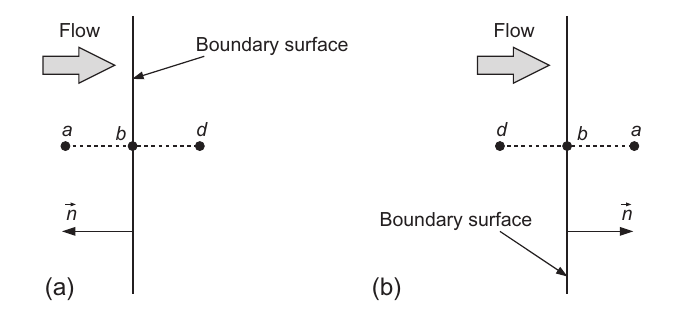

## Характеристические граничные условия
### Сверхзвуковой вход
$$\vec u_b = \vec u_a$$

OpenFOAM: type fixedValue

### Сверхзвуковой выход
$$\vec u_b = \vec u_d$$

OpenFOAM: type zeroGradient

### Дозвуковой вход
$$p_b = 1/2 (p_a + p_d - \rho_0 c_0 [\vec n \cdot (\vec U_a - \vec U_d)]) \\
\rho_b = \rho_a + (p_b-p_a)/c_0^2 \\
\vec U_b = \vec U_a - \vec n (p_a-p_b)/(\rho_0 c_0)
$$

OpenFOAM: [hisa code](https://gitlab.com/hisa/hisa/-/tree/master/src/finiteVolume/boundaryConditions/characteristic/characteristicFarfield)

### Дозвуковой выход
$$p_b = p_a \\
\rho_b = \rho_d + (p_b-p_d)/c_0^2 \\
\vec U_b = \vec U_d + \vec n (p_d-p_b)/(\rho_0 c_0)
$$

OpenFOAM: [hisa code](https://gitlab.com/hisa/hisa/-/tree/master/src/finiteVolume/boundaryConditions/characteristic/characteristicFarfield)

## На стенке
Условие проскальзывания $$\vec u_n = \vec 0 \\ \vec u_{\tau wall} =  \vec u_{\tau c}$$
OpenFOAM: type slip

## Пример OpenFOAM <a name="euler_tut"></a> 

tutorials: compressible/rhoCentralFoam/forwardStep

Woodward and Collela

In [2]:
ls forwardStep

0/    0.4/  0.8/  1.2/  1.6/  2/    2.4/  2.8/  3.2/  3.6/  4/
0.1/  0.5/  0.9/  1.3/  1.7/  2.1/  2.5/  2.9/  3.3/  3.7/  constant/
0.2/  0.6/  1/    1.4/  1.8/  2.2/  2.6/  3/    3.4/  3.8/  foam.foam
0.3/  0.7/  1.1/  1.5/  1.9/  2.3/  2.7/  3.1/  3.5/  3.9/  system/


<img src="forwardStep/geom.png" width="800" height="200">

In [5]:
!cat forwardStep/constant/thermophysicalProperties

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "constant";
    object      thermophysicalProperties;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

thermoType
{
    type            hePsiThermo;
    mixture         pureMixture;
    transport       const;
    thermo          hConst;
    equationOfState perfectGas;
    specie          specie;
    energy

In [6]:
!cat forwardStep/system/fvSchemes

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSchemes;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

fluxScheme      Kurganov;

ddtSchemes
{
    default         Euler;
}

gradSchemes
{
    default         Gauss linear;
}

divSchemes
{
    default         none;
    div(tauMC)      Gauss linear;
}

laplacianSchemes
{
    d

In [7]:
!cat forwardStep/0/T

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       volScalarField;
    object      T;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

dimensions      [0 0 0 1 0 0 0];

internalField   uniform 1;

boundaryField
{
    inlet
    {
        type            fixedValue;
        value           uniform 1;
    }

    outlet
    {
        type            inletOutlet;
        inletValue      u

In [8]:
!cat forwardStep/0/p

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       volScalarField;
    object      p;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

dimensions      [1 -1 -2 0 0 0 0];

internalField   uniform 1;

boundaryField
{
    inlet
    {
        type            fixedValue;
        value           uniform 1;
    }

    outlet
    {
        type            zeroGradient;
    }

    bottom
    

In [9]:
!cat forwardStep/0/U

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       volVectorField;
    object      U;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

dimensions      [0 1 -1 0 0 0 0];

internalField   uniform (3 0 0);

boundaryField
{
    inlet
    {
        type            fixedValue;
        value           uniform (3 0 0);
    }

    outlet
    {
        type            inletOutlet;
        inle

In [10]:
!cat forwardStep/system/controlDict

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      controlDict;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

application     rhoCentralFoam;

startFrom       startTime;

startTime       0;

stopAt          endTime;

endTime         4;

deltaT          0.002;

writeControl    adjustable;

writeInterval   0.1;

purgeWrite      0

In [11]:
#!rhoCentralFoam -case forwardStep

<img src="forwardStep/result.png" width="700" height="200">
<img src="forwardStep/streamTrace.png" width="700" height="200">
<img src="forwardStep/isolines.png" width="700" height="200">
<img src="img/wc.jpeg" width="700" height="200">

## Заключение

1. [Density-Based solvers OpenFOAM](#dbof)
2. [Граничные условия Эйлер](#bceuler)
3. [Примеры OpenFOAM](#euler_tut)

## В следующей серии ...

Система уравнений Навье-Стокса, турбулентность! 

<table><tr>
<td> <img src="img/ns.jpg" width="500" height="200"> </td>
<td> <img src="img/turb.jpg" width="500" height="200"> </td>
</tr></table>
